In [1]:
%pylab inline
import pandas as pd
from matplotlib import dates as mdates
from scipy.signal import savgol_filter
import pwlf, json, os
# import statsmodels.api as sm
# from scipy.interpolate import interp1d

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [5]:

# File path
year = 2023
file_path = f'gridstatus_price/daily_price_demand_{year}.csv'

# Read the CSV file
data = pd.read_csv(file_path)


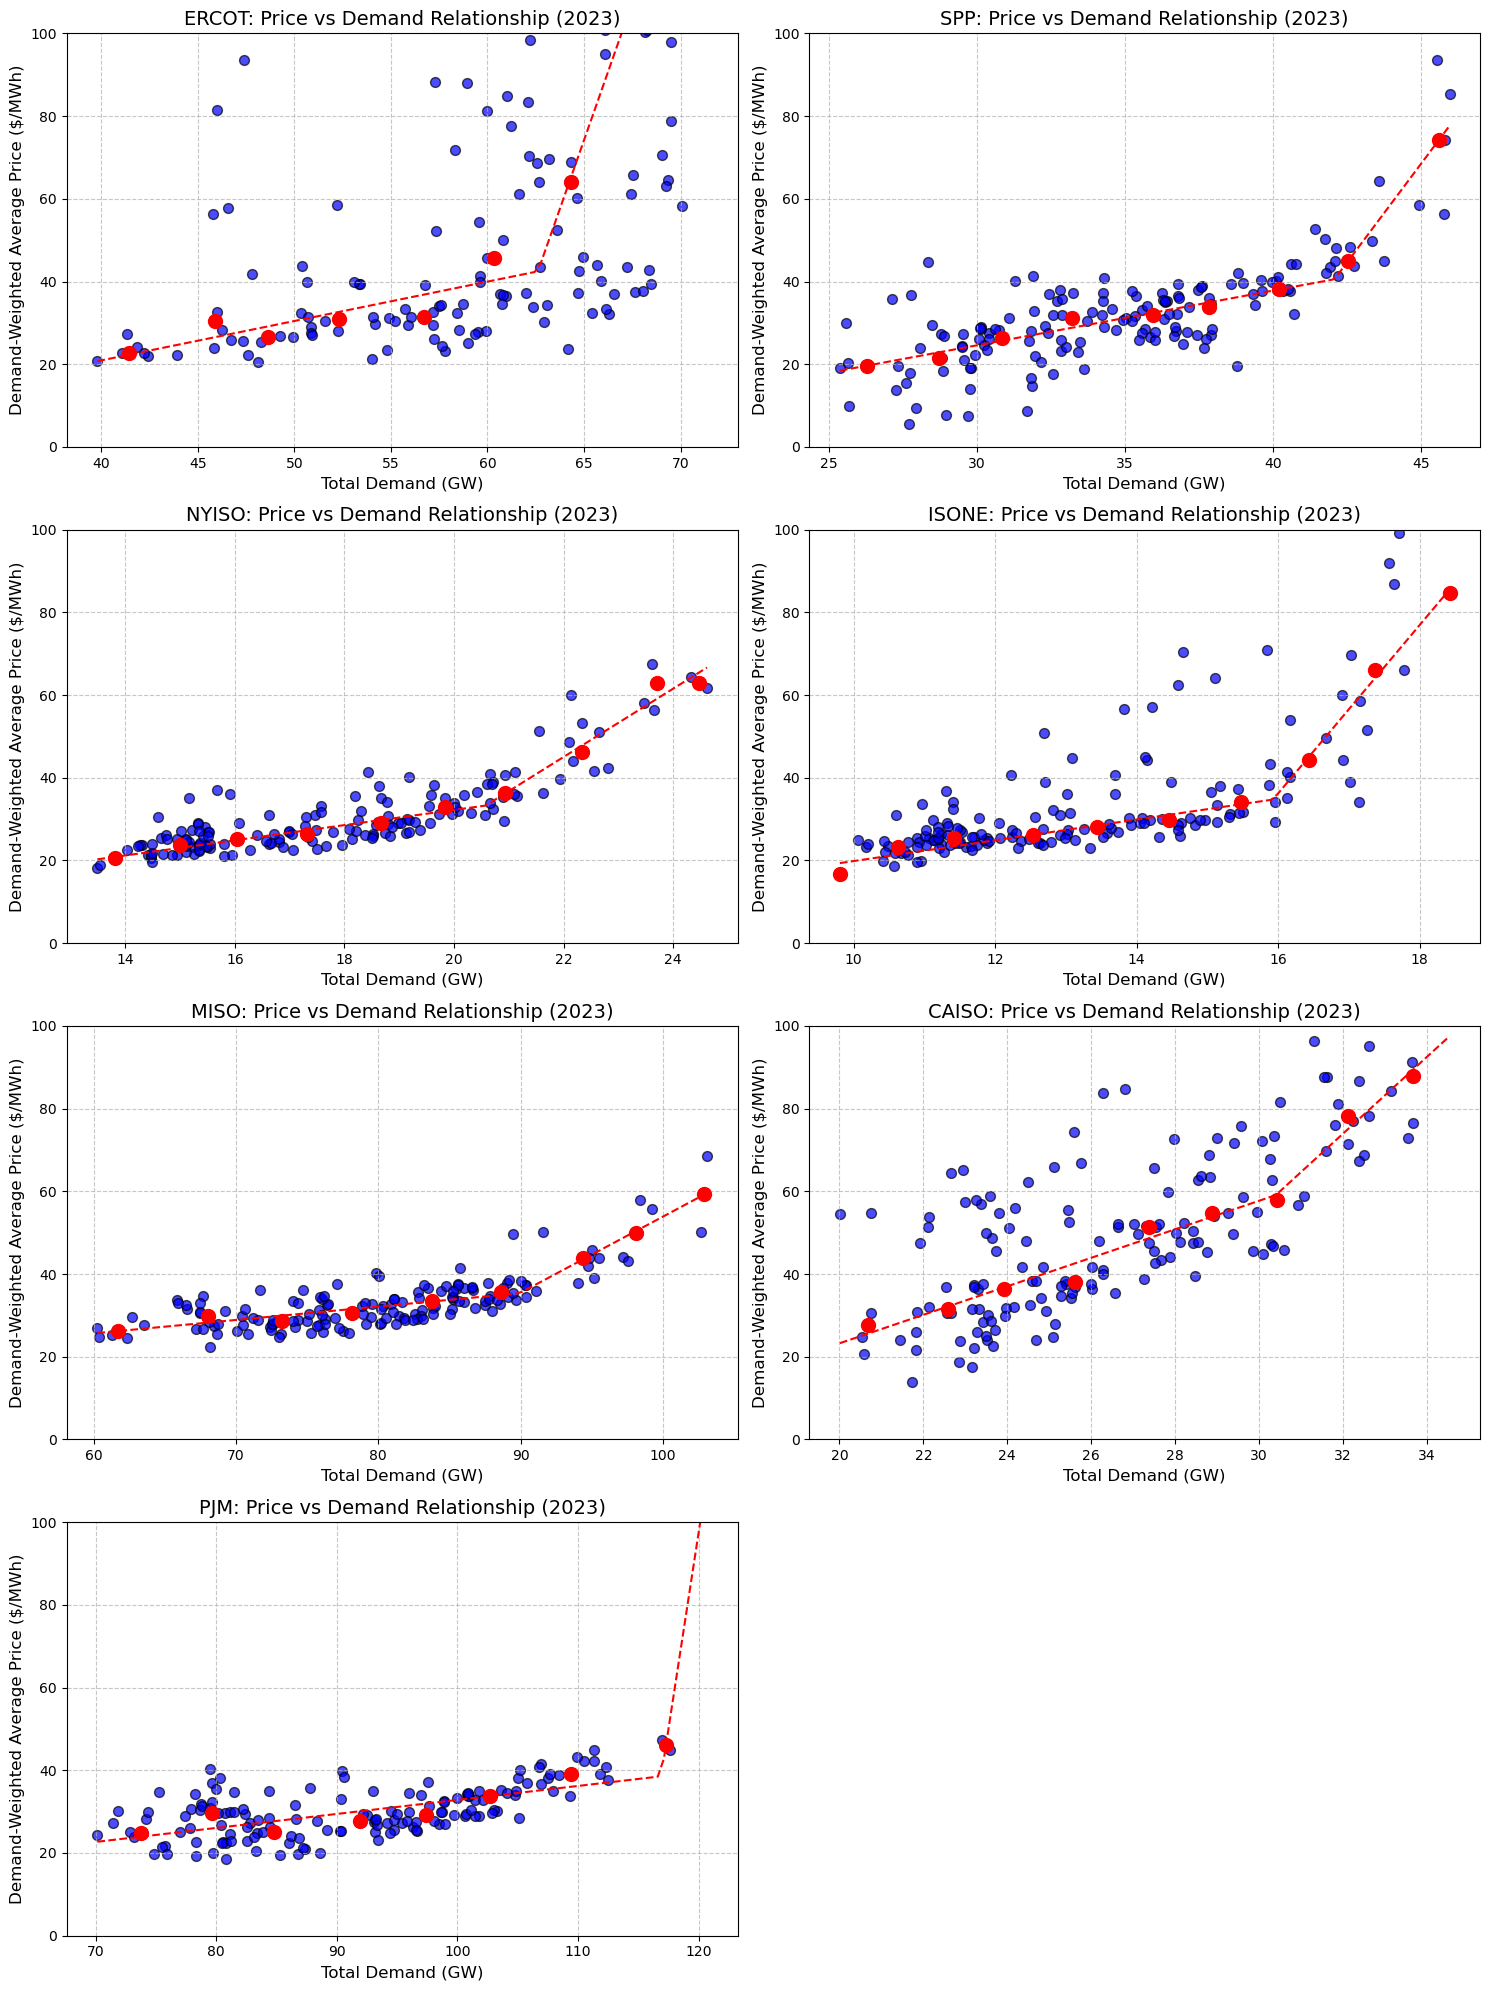

In [6]:
# Get unique RTOs
rtos = data['RTO'].unique()
n_rtos = len(rtos)
smoothed_dict = {}
pwlf_dict = {}  # Dictionary to store pwlf parameters

# Calculate number of rows and columns for subplots
n_cols = 2
n_rows = (n_rtos + 1) // 2  # Round up division

# Set up the plot style
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten()  # Flatten axes array for easier indexing

# Plot each RTO
for i, rto in enumerate(rtos):
    # Filter for current RTO
    rto_data = data[data['RTO'] == rto].copy()
    
    # Convert 'Local Date' to datetime format
    rto_data['Local Date'] = pd.to_datetime(rto_data['Local Date'])
    
    # Filter for summer months
    rto_data = rto_data[(rto_data['Local Date'].dt.month >= 6) & (rto_data['Local Date'].dt.month <= 10)]
    
    # Calculate piecewise linear fit with binned data
    x = rto_data['Total Demand'].values
    y = rto_data['Demand-Weighted Avg Price'].values
    if rto == 'PJM':
        y = y[x > 30]
        x = x[x > 30]
    
    # Create 5 GW wide bins
    bin_width = (np.floor(x.max()) - np.ceil(x.min()))/8
    bins = np.arange(np.floor(x.min()), np.ceil(x.max()) + bin_width, bin_width)
    
    # Calculate median price for each bin
    binned_data = pd.DataFrame({'x': x, 'y': y})
    binned_data['bin'] = pd.cut(x, bins=bins)
    medians = binned_data.groupby('bin', observed=True).agg({'x': 'mean', 'y': 'median'}).dropna()
    
    # Fit piecewise linear on binned medians
    my_pwlf = pwlf.PiecewiseLinFit(medians['x'].values, medians['y'].values)
    # Fit 2 line segments (3 breakpoints including endpoints)
    my_pwlf.fit(2)
    
    # Store pwlf parameters
    pwlf_dict[rto] = {
        'breakpoints': my_pwlf.fit_breaks.tolist(),
        'slopes': my_pwlf.slopes.tolist(),
        'intercepts': my_pwlf.intercepts.tolist()
    }

    # Create the scatter plot
    axes[i].scatter(x,y,alpha=0.7, color='blue', edgecolors='black', s=50)
    
    # Add labels and title
    axes[i].set_xlabel('Total Demand (GW)', fontsize=12)
    axes[i].set_ylabel('Demand-Weighted Average Price ($/MWh)', fontsize=12)
    axes[i].set_title(f'{rto}: Price vs Demand Relationship ({year})',fontsize=14)
    axes[i].set_ylim(0, 100)
    
    # Add grid
    axes[i].grid(True, linestyle='--', alpha=0.7)
    
    # Get x and y coordinates for plotting
    x_hat = np.linspace(x.min(), x.max(), 100)
    y_hat = my_pwlf.predict(x_hat)
    
    # Plot the binned medians as points and the piecewise fit
    axes[i].scatter(medians['x'], medians['y'], color='red', s=100, zorder=5, label='Bin Medians')
    axes[i].plot(x_hat, y_hat, 'r--', label='Piecewise Fit')
    # axes[i].legend()

    # Save to dictionary
    interpolated_y = np.interp(np.arange(131), x_hat, y_hat, left=np.nan, right=np.nan)
    smoothed_dict[rto] = interpolated_y

# Remove any empty subplots
for i in range(n_rtos, len(axes)):
    fig.delaxes(axes[i])

# Improve layout
plt.tight_layout()

# Create plots directory if it doesn't exist
os.makedirs('plots', exist_ok=True)

# Save plot with year in filename
plot_path = f'plots/price_demand_relationships_{year}.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

# save smoothed y to CSV with RTO index
# Convert smoothed_dict to DataFrame with equal length arrays
smoothed_df = pd.DataFrame.from_dict(smoothed_dict, orient='index')
smoothed_df.index.names = ['RTO']  # Add RTO names as index
#smoothed_df.to_csv(f'price_demand_smooth_{year}.csv', index=True)

# Save pwlf parameters to JSON
with open(f'gridstatus_price/price_demand_pwlf_{year}.json', 'w') as f:
    json.dump(pwlf_dict, f, indent=4)

In [4]:

# File path
year = 2023
file_path = f'price/daily_price_demand_{year}.csv'

# Read the CSV file
data = pd.read_csv(file_path)


FileNotFoundError: [Errno 2] No such file or directory: 'price/daily_price_demand_2023.csv'

In [5]:
# Get unique RTOs
rtos = data['RTO'].unique()
n_rtos = len(rtos)
smoothed_dict = {}
pwlf_dict = {}  # Dictionary to store pwlf parameters

# Calculate number of rows and columns for subplots
n_cols = 2
n_rows = (n_rtos + 1) // 2  # Round up division

# Set up the plot style
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten()  # Flatten axes array for easier indexing

# Plot each RTO
for i, rto in enumerate(rtos):
    # Filter for current RTO
    rto_data = data[data['RTO'] == rto].copy()
    
    # Convert 'Local Date' to datetime format
    rto_data['Local Date'] = pd.to_datetime(rto_data['Local Date'])
    
    # Filter for summer months
    rto_data = rto_data[(rto_data['Local Date'].dt.month >= 6) & (rto_data['Local Date'].dt.month <= 10)]
    
    # Calculate piecewise linear fit with binned data
    x = rto_data['Total Demand'].values
    y = rto_data['Demand-Weighted Avg Price'].values
    if rto == 'PJM':
        y = y[x > 30]
        x = x[x > 30]
    
    # Create 5 GW wide bins
    bin_width = (np.floor(x.max()) - np.ceil(x.min()))/8
    bins = np.arange(np.floor(x.min()), np.ceil(x.max()) + bin_width, bin_width)
    
    # Calculate median price for each bin
    binned_data = pd.DataFrame({'x': x, 'y': y})
    binned_data['bin'] = pd.cut(x, bins=bins)
    medians = binned_data.groupby('bin', observed=True).agg({'x': 'mean', 'y': 'median'}).dropna()
    
    # Fit piecewise linear on binned medians
    my_pwlf = pwlf.PiecewiseLinFit(medians['x'].values, medians['y'].values)
    # Fit 2 line segments (3 breakpoints including endpoints)
    my_pwlf.fit(2)
    
    # Store pwlf parameters
    pwlf_dict[rto] = {
        'breakpoints': my_pwlf.fit_breaks.tolist(),
        'slopes': my_pwlf.slopes.tolist(),
        'intercepts': my_pwlf.intercepts.tolist()
    }

    # Create the scatter plot
    axes[i].scatter(x,y,alpha=0.7, color='blue', edgecolors='black', s=50)
    
    # Add labels and title
    axes[i].set_xlabel('Total Demand (GW)', fontsize=12)
    axes[i].set_ylabel('Demand-Weighted Average Price ($/MWh)', fontsize=12)
    axes[i].set_title(f'{rto}: Price vs Demand Relationship ({year})', fontsize=14)
    
    # Add grid
    axes[i].grid(True, linestyle='--', alpha=0.7)
    
    # Get x and y coordinates for plotting
    x_hat = np.linspace(x.min(), x.max(), 100)
    y_hat = my_pwlf.predict(x_hat)
    
    # Plot the binned medians as points and the piecewise fit
    axes[i].scatter(medians['x'], medians['y'], color='red', s=100, zorder=5, label='Bin Medians')
    axes[i].plot(x_hat, y_hat, 'r--', label='Piecewise Fit')
    # axes[i].legend()

    # Save to dictionary
    interpolated_y = np.interp(np.arange(131), x_hat, y_hat, left=np.nan, right=np.nan)
    smoothed_dict[rto] = interpolated_y

# Remove any empty subplots
for i in range(n_rtos, len(axes)):
    fig.delaxes(axes[i])

# Improve layout
plt.tight_layout()

# Save the figure
output_path = 'all_rtos_demand_price_plot.png'
# plt.savefig(output_path, dpi=300)
# print(f"Plot saved to {output_path}")

# Show the plot
plt.show()

# save smoothed y to CSV with RTO index
# Convert smoothed_dict to DataFrame with equal length arrays
smoothed_df = pd.DataFrame.from_dict(smoothed_dict, orient='index')
smoothed_df.index.names = ['RTO']  # Add RTO names as index
#smoothed_df.to_csv(f'price_demand_smooth_{year}.csv', index=True)

# Save pwlf parameters to JSON
with open(f'price_demand_pwlf_{year}.json', 'w') as f:
    json.dump(pwlf_dict, f, indent=4)

NameError: name 'data' is not defined

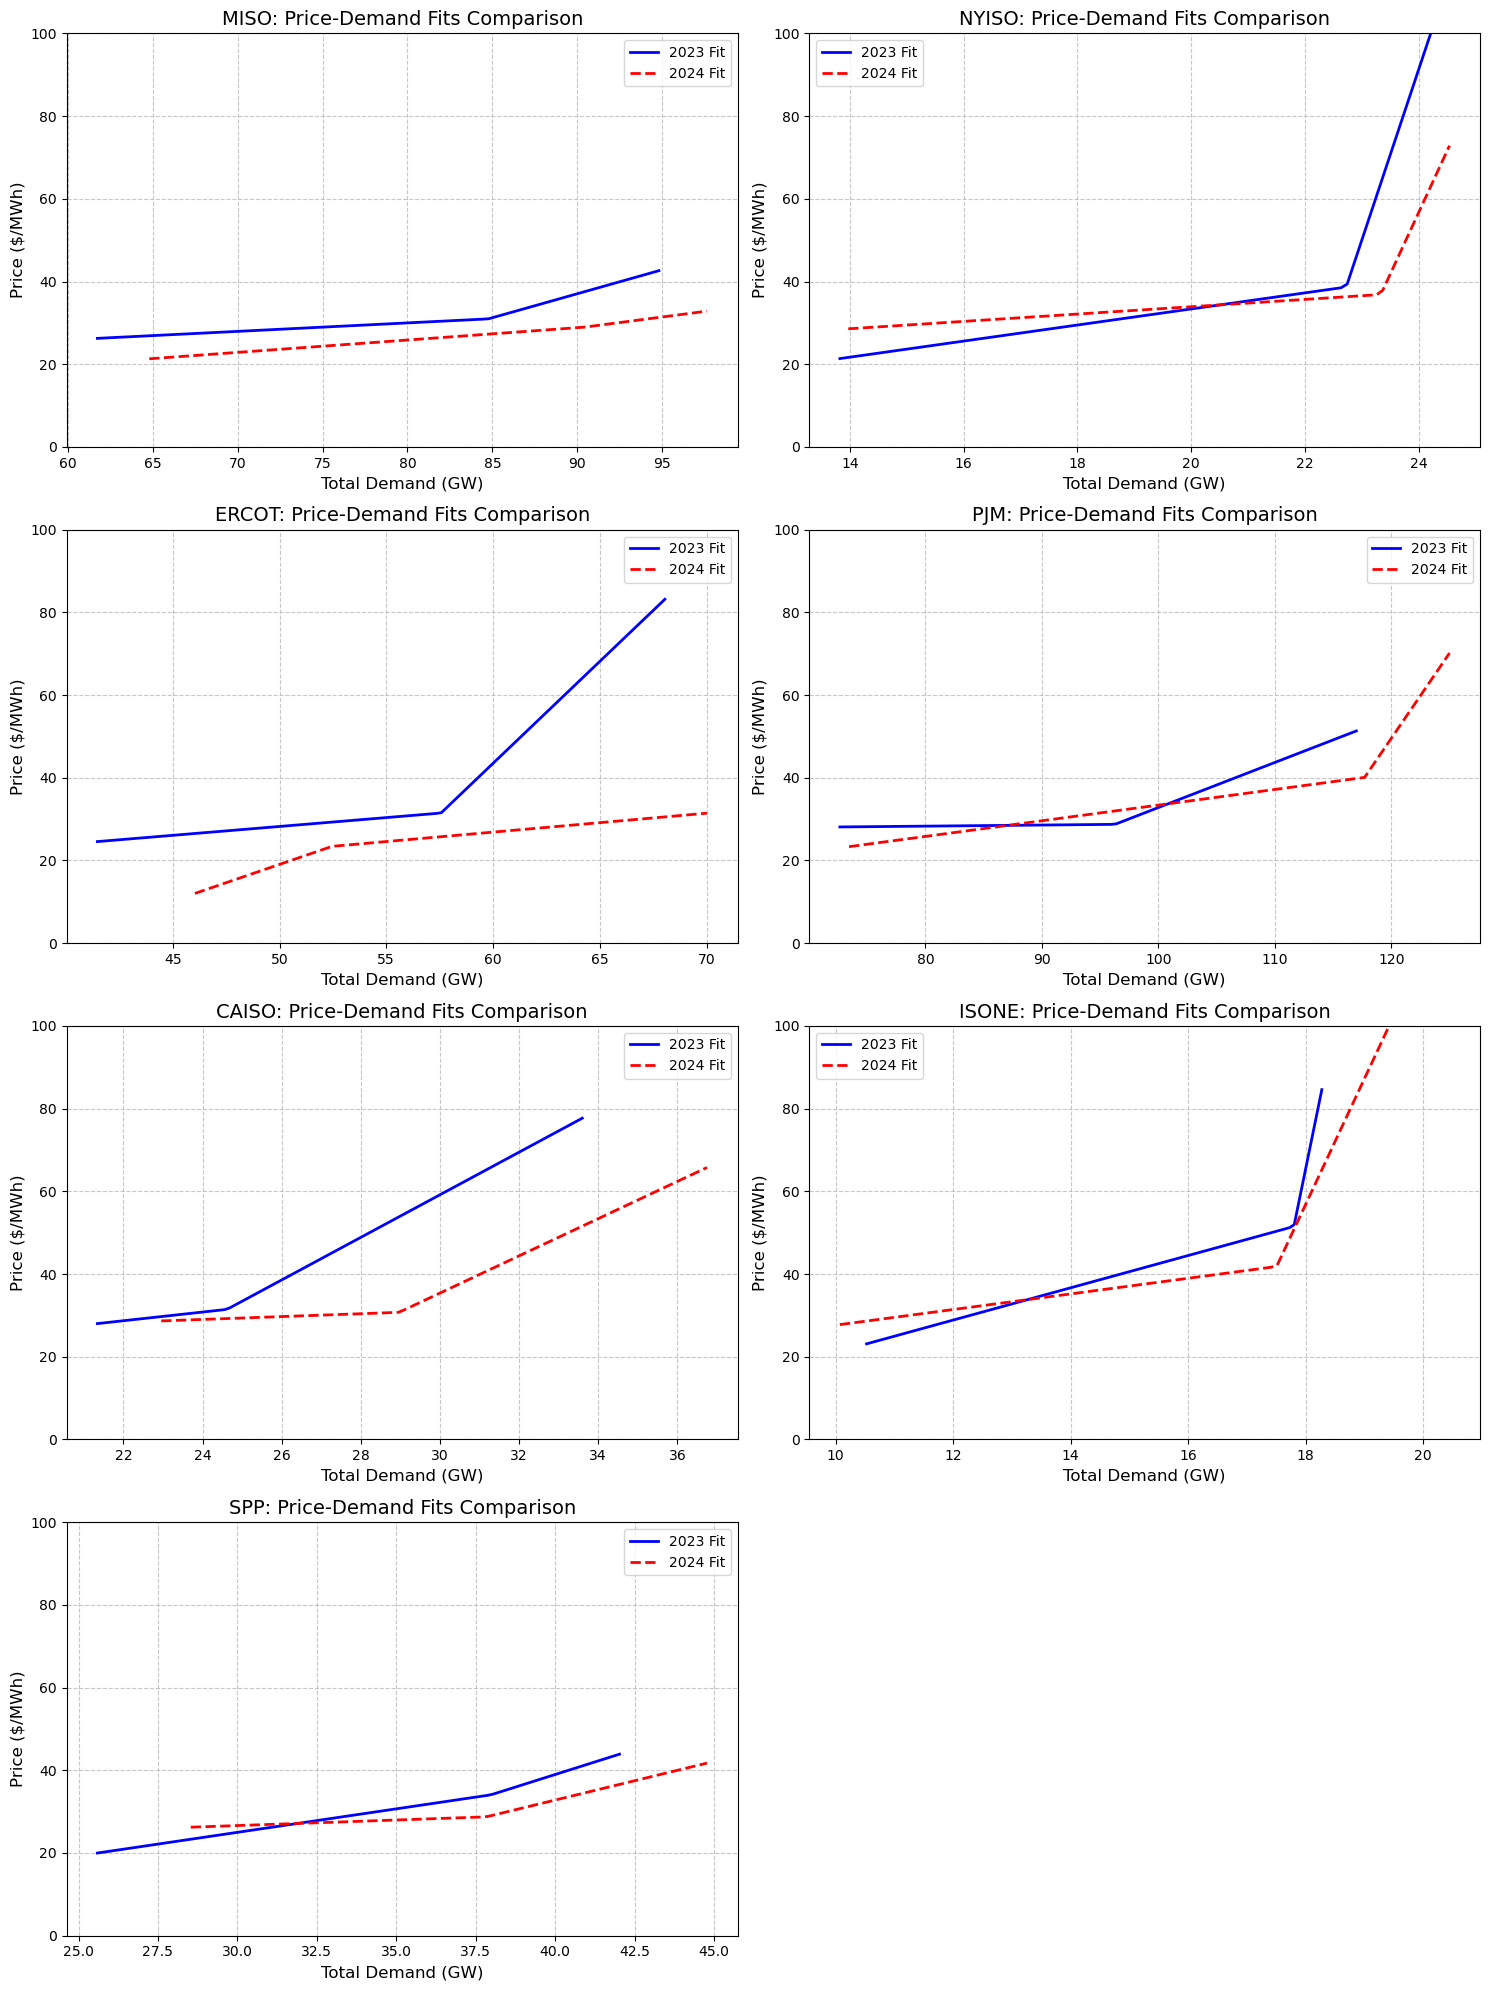

In [29]:
# Compare 2023 and 2024 fits for each RTOs
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten()

# Load 2023 and 2024 pwlf parameters
with open('price_demand_pwlf_2023.json', 'r') as f:
    pwlf_2023 = json.load(f)
with open('price_demand_pwlf_2024.json', 'r') as f:
    pwlf_2024 = json.load(f)

for i, rto in enumerate(rtos):
    # Get parameters for both years
    params_2023 = pwlf_2023[rto]
    params_2024 = pwlf_2024[rto]
    
    # Generate x values for each year separately
    x_2023 = np.linspace(np.array(params_2023['breakpoints']).min(), 
                        np.array(params_2023['breakpoints']).max(), 100)
    x_2024 = np.linspace(np.array(params_2024['breakpoints']).min(),
                        np.array(params_2024['breakpoints']).max(), 100)
    
    # Calculate y values for 2023
    y_2023 = []
    for x_val in x_2023:
        for j in range(len(params_2023['breakpoints'])-1):
            if x_val >= params_2023['breakpoints'][j] and x_val <= params_2023['breakpoints'][j+1]:
                y_2023.append(params_2023['slopes'][j] * x_val + params_2023['intercepts'][j])
                break
        else:
            if x_val < params_2023['breakpoints'][0]:
                y_2023.append(params_2023['slopes'][0] * x_val + params_2023['intercepts'][0])
            else:
                y_2023.append(params_2023['slopes'][-1] * x_val + params_2023['intercepts'][-1])
    
    # Calculate y values for 2024
    y_2024 = []
    for x_val in x_2024:
        for j in range(len(params_2024['breakpoints'])-1):
            if x_val >= params_2024['breakpoints'][j] and x_val <= params_2024['breakpoints'][j+1]:
                y_2024.append(params_2024['slopes'][j] * x_val + params_2024['intercepts'][j])
                break
        else:
            if x_val < params_2024['breakpoints'][0]:
                y_2024.append(params_2024['slopes'][0] * x_val + params_2024['intercepts'][0])
            else:
                y_2024.append(params_2024['slopes'][-1] * x_val + params_2024['intercepts'][-1])

    # Plot both curves
    axes[i].plot(x_2023, y_2023, 'b-', label='2023 Fit', linewidth=2)
    axes[i].plot(x_2024, y_2024, 'r--', label='2024 Fit', linewidth=2)
    
    # Add labels and title
    axes[i].set_xlabel('Total Demand (GW)', fontsize=12)
    axes[i].set_ylabel('Price ($/MWh)', fontsize=12)
    axes[i].set_title(f'{rto}: Price-Demand Fits Comparison', fontsize=14)
    axes[i].legend()
    axes[i].grid(True, linestyle='--', alpha=0.7)
    axes[i].set_ylim(0, 100)

# Remove any empty subplots
for i in range(n_rtos, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


In [15]:
x_min = min([np.array(params_2024['breakpoints']).min(), np.array(params_2024['breakpoints']).min()])
x_min

np.float64(13.967142857142857)

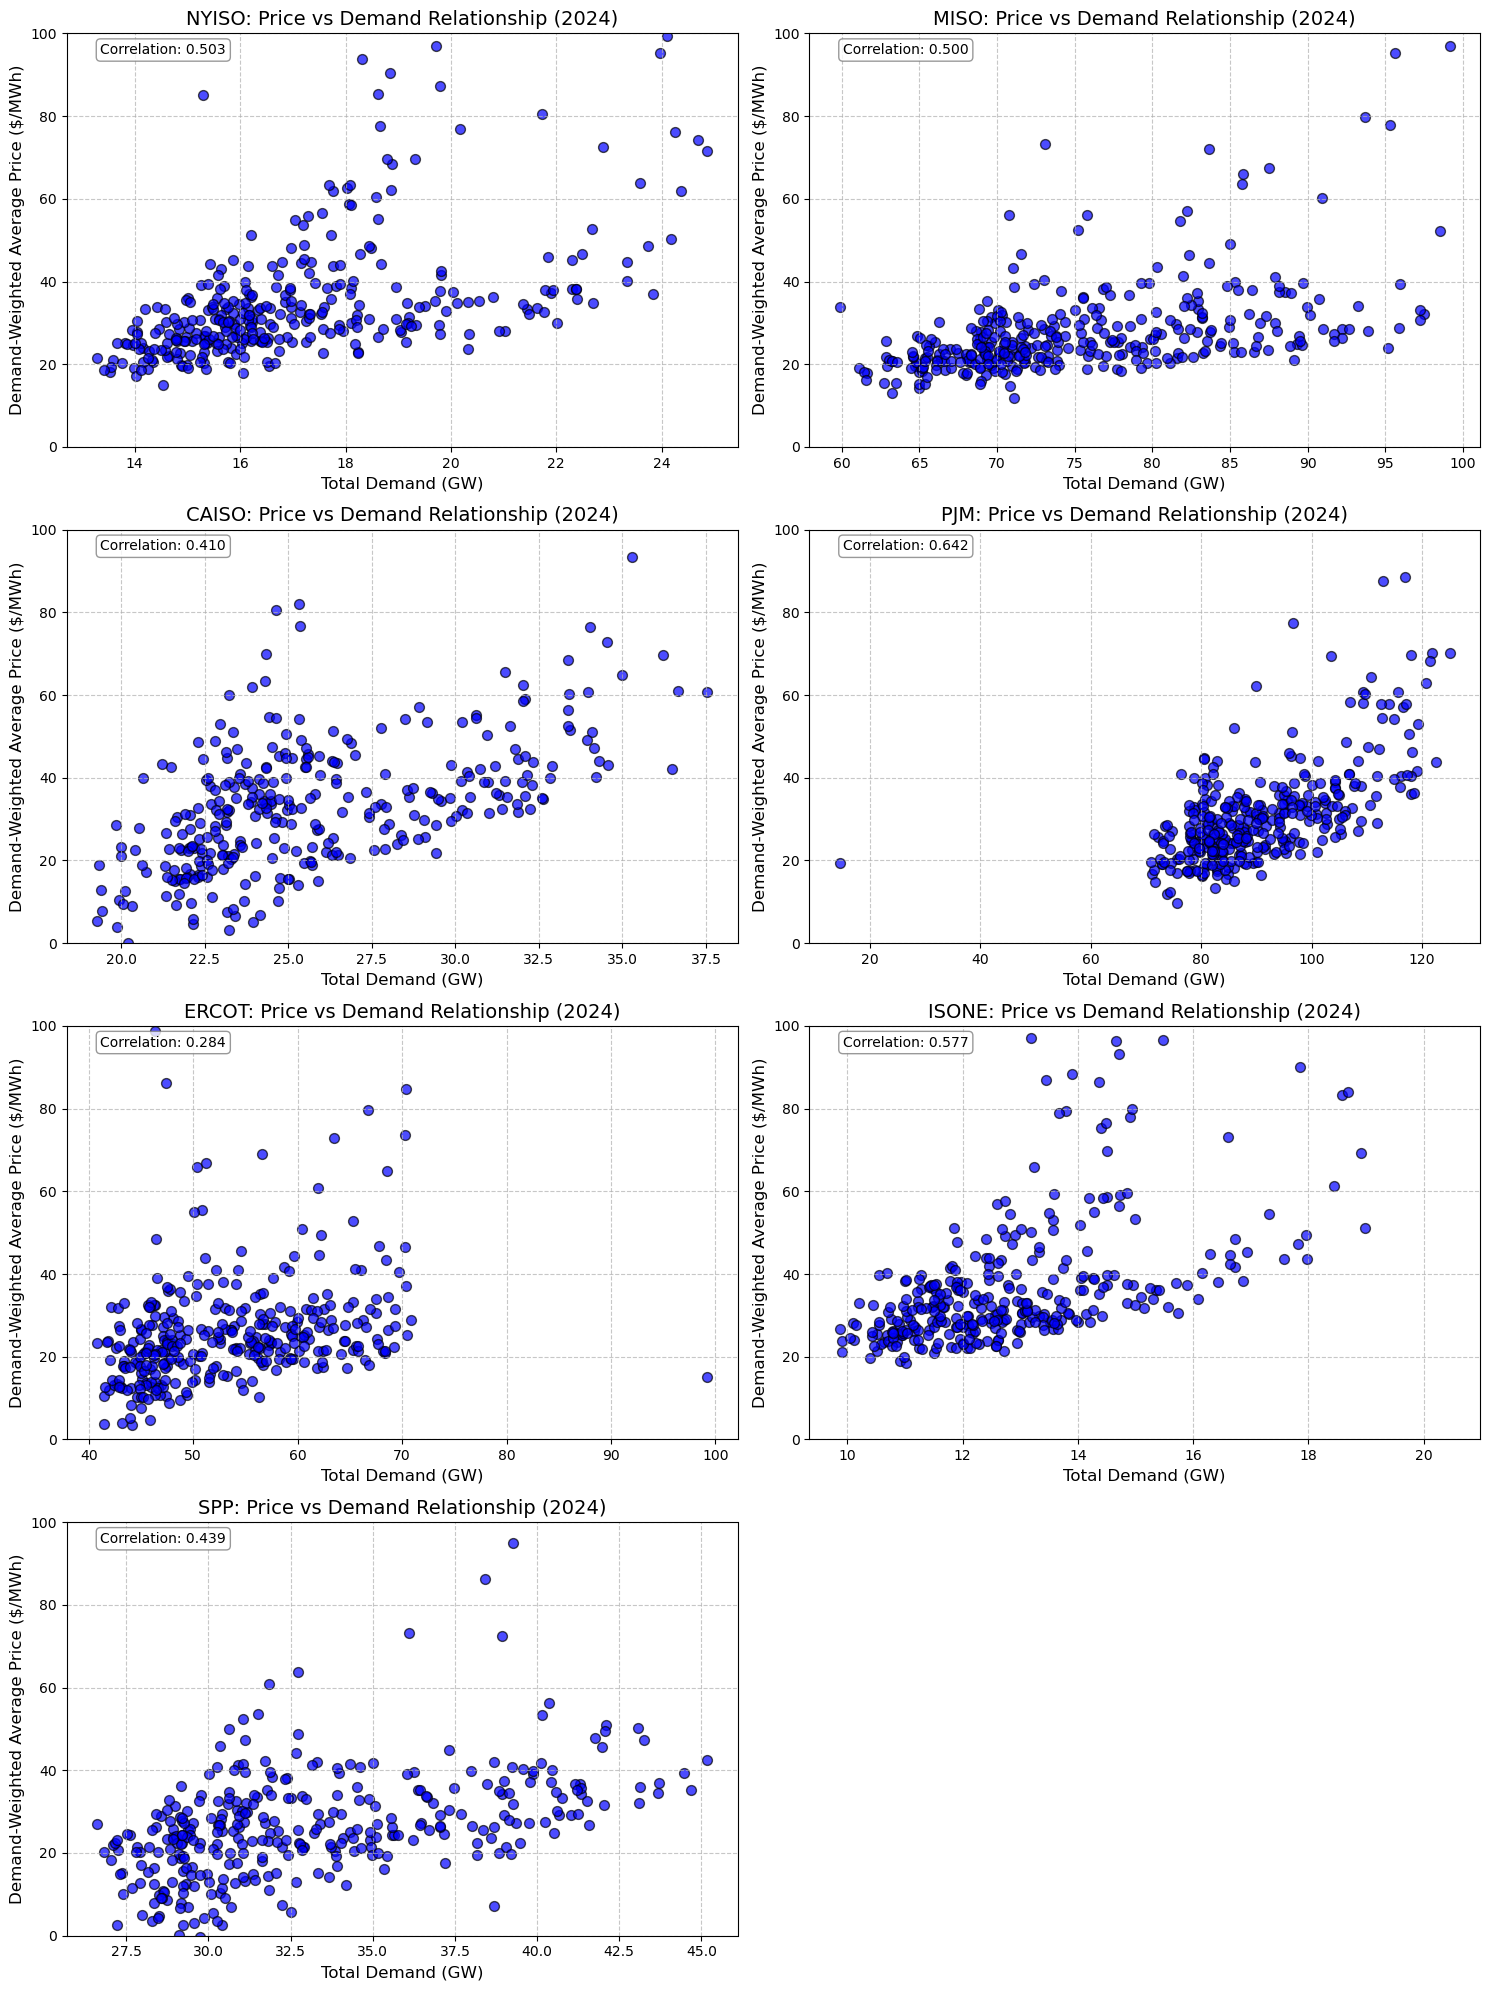

In [6]:
# Get unique RTOs
rtos = data['RTO'].unique()
n_rtos = len(rtos)

# Calculate number of rows and columns for subplots
n_cols = 2
n_rows = (n_rtos + 1) // 2  # Round up division

# Set up the plot style
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten()  # Flatten axes array for easier indexing

# Plot each RTO
for i, rto in enumerate(rtos):
    # Filter for current RTO
    rto_data = data[data['RTO'] == rto]
    
    # Create the scatter plot
    axes[i].scatter(rto_data['Total Demand'], rto_data['Demand-Weighted Avg Price'],
                   alpha=0.7, color='blue', edgecolors='black', s=50)
    
    # Add labels and title
    axes[i].set_xlabel('Total Demand (GW)', fontsize=12)
    axes[i].set_ylabel('Demand-Weighted Average Price ($/MWh)', fontsize=12)
    axes[i].set_title(f'{rto}: Price vs Demand Relationship ({year})', fontsize=14)
    
    # Add grid
    axes[i].grid(True, linestyle='--', alpha=0.7)
    
    # Calculate correlation
    correlation = rto_data['Total Demand'].corr(rto_data['Demand-Weighted Avg Price'])
    axes[i].set_ylim(0, 100)
    axes[i].annotate(f'Correlation: {correlation:.3f}',
                    xy=(0.05, 0.95), xycoords='axes fraction',
                    fontsize=10, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

# Remove any empty subplots
for i in range(n_rtos, len(axes)):
    fig.delaxes(axes[i])

# Improve layout
plt.tight_layout()

# Save the figure
output_path = f'all_rtos_demand_price_plot_{year}.png'
#plt.savefig(output_path, dpi=300)
#print(f"Plot saved to {output_path}")

# Show the plot
plt.show()

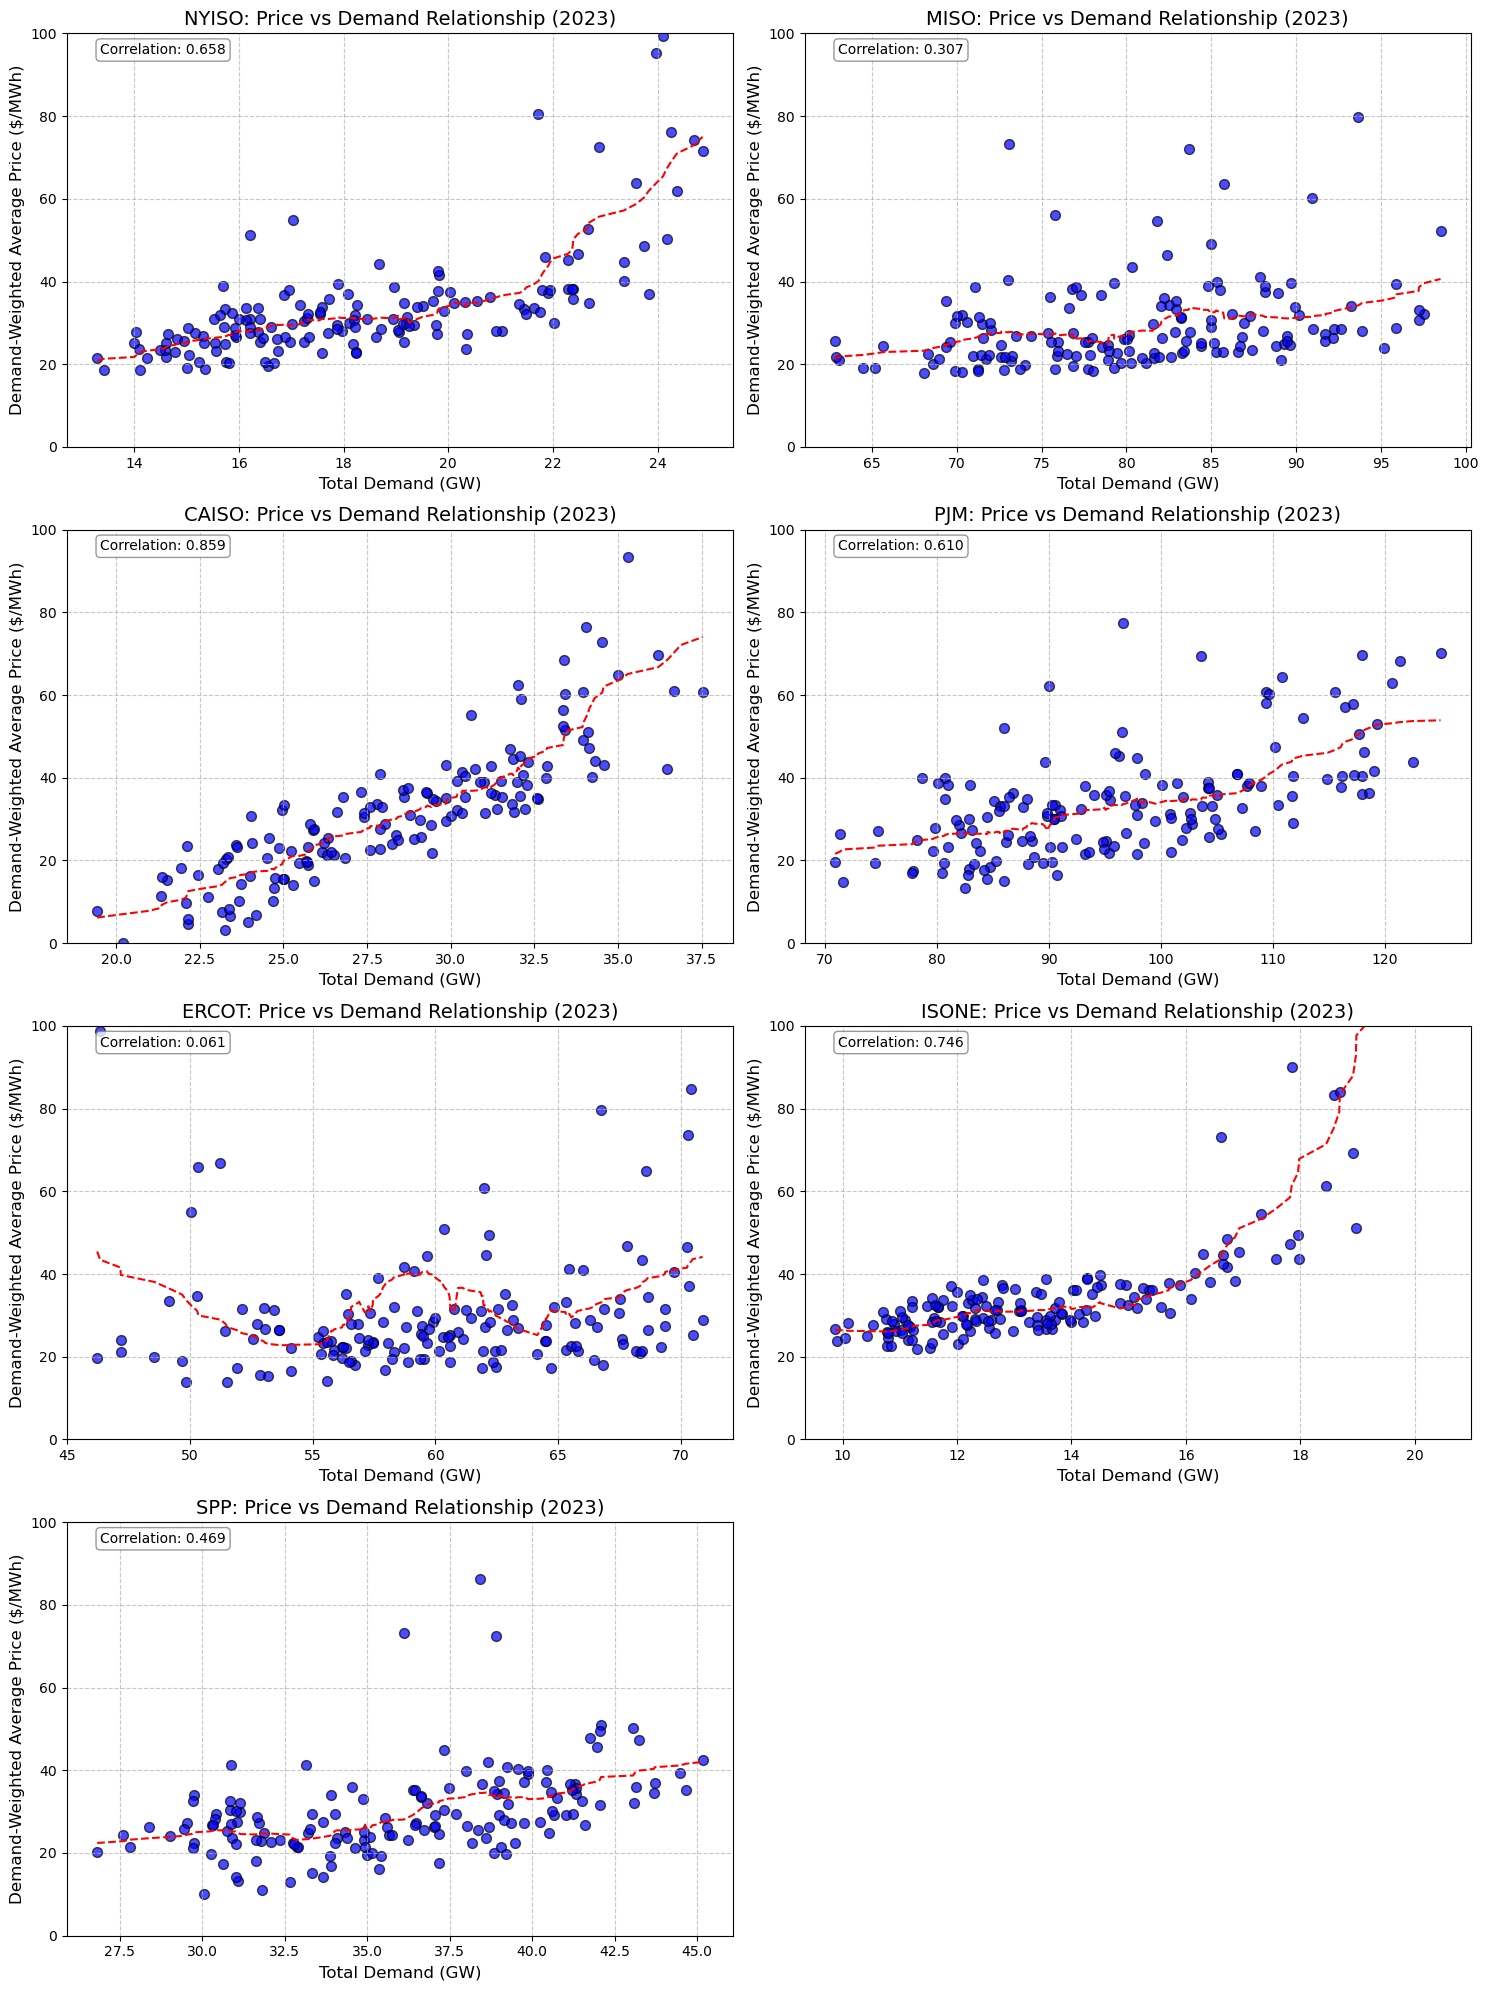

In [7]:
# Get unique RTOs
rtos = data['RTO'].unique()
n_rtos = len(rtos)
smoothed_dict = {}

# Calculate number of rows and columns for subplots
n_cols = 2
n_rows = (n_rtos + 1) // 2  # Round up division

# Set up the plot style
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten()  # Flatten axes array for easier indexing

# Plot each RTO
for i, rto in enumerate(rtos):
    # Filter for current RTO
    rto_data = data[data['RTO'] == rto].copy()
    
    # Convert 'Local Date' to datetime format
    rto_data['Local Date'] = pd.to_datetime(rto_data['Local Date'])
    
    # Filter for summer months
    rto_data = rto_data[(rto_data['Local Date'].dt.month >= 5) & (rto_data['Local Date'].dt.month <= 9)]
    
    # Create the scatter plot
    axes[i].scatter(rto_data['Total Demand'], rto_data['Demand-Weighted Avg Price'],
                   alpha=0.7, color='blue', edgecolors='black', s=50)
    
    # Add labels and title
    axes[i].set_xlabel('Total Demand (GW)', fontsize=12)
    axes[i].set_ylabel('Demand-Weighted Average Price ($/MWh)', fontsize=12)
    axes[i].set_title(f'{rto}: Price vs Demand Relationship (2023)', fontsize=14)
    
    # Add grid
    axes[i].grid(True, linestyle='--', alpha=0.7)
    
    # Calculate correlation
    correlation = rto_data['Total Demand'].corr(rto_data['Demand-Weighted Avg Price'])
    axes[i].set_ylim(0, 100)
    axes[i].annotate(f'Correlation: {correlation:.3f}',
                    xy=(0.05, 0.95), xycoords='axes fraction',
                    fontsize=10, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
    
    # Add smoothed fit
    x = rto_data['Total Demand'].drop_duplicates().sort_values()
    y = rto_data['Demand-Weighted Avg Price'][x.index]
    # Ensure x and y have the same length by removing duplicates from y
    smoothed_y = savgol_filter(y, 61, 3)  # window size 51, polynomial order 3
    axes[i].plot(x, smoothed_y, 'r--')

    # Save to dictionary
    interpolated_y = np.interp(np.arange(131), x, smoothed_y, left=np.nan, right=np.nan)
    smoothed_dict[rto] = interpolated_y

# Remove any empty subplots
for i in range(n_rtos, len(axes)):
    fig.delaxes(axes[i])

# Improve layout
plt.tight_layout()

# Save the figure
output_path = 'all_rtos_demand_price_plot.png'
#plt.savefig(output_path, dpi=300)
#print(f"Plot saved to {output_path}")

# Show the plot
plt.show()

# save smoothed y to CSV with RTO index
# Convert smoothed_dict to DataFrame with equal length arrays
smoothed_df = pd.DataFrame.from_dict(smoothed_dict, orient='index')
smoothed_df.index.names = ['RTO']  # Add RTO names as index
# smoothed_df.to_csv(f'price_demand_smooth_{year}.csv', index=True)

In [8]:
x1 = pd.read_csv('price/caiso_lmp_da_hr_zones_2024.csv',skiprows=3)
x1 = x1.groupby(['Local Date']).agg({
    'NP-15 LMP': 'mean',
    'SP-15 LMP': 'mean', 
    'ZP-26 LMP': 'mean',
    'NP-15 (Congestion)': 'mean',
    'SP-15 (Congestion)': 'mean',
    'ZP-26 (Congestion)': 'mean',
    'NP-15 (Energy)': 'mean',
    'SP-15 (Energy)': 'mean',
    'ZP-26 (Energy)': 'mean',
    'NP-15 (Loss)': 'mean',
    'SP-15 (Loss)': 'mean',
    'ZP-26 (Loss)': 'mean'
})
x1 = x1.iloc[:,0:3].mean(axis=1)
x1.index = pd.to_datetime(x1.index)
x1.head()

Local Date
2024-01-01    42.158326
2024-01-02    46.674410
2024-01-03    47.587660
2024-01-05    61.497502
2024-01-06    59.922256
dtype: float64